In [1]:
import numpy as np
import astropy.units as u
from astropy.cosmology import Planck13 as cosmo
from astropy import constants as const

from scipy.interpolate import interp1d as i1d
from scipy.interpolate import interp2d as i2d
from scipy.special import legendre

import camb

import pickle

from scipy.integrate import quad
from scipy.integrate import fixed_quad
from scipy.integrate import romberg

import matplotlib.pyplot as plt
import matplotlib.pylab as pylab

from scipy.fft import fft,ifft
import matplotlib.gridspec as gridspec
from scipy.stats import poisson

from classy import Class

from scipy.interpolate import interp1d
from scipy.interpolate import interp2d

import powerbox as pbox



In [2]:
# Creat an instance of the class for the VID computation

import VID_CO
from VID_CO import VIDco

We define a dectionary for the CO mission we are looking at.

In [3]:
CO= {"tobs": 6000 * u.hour ,"z": (115.271/30)- 1  ,"beam" : 4*u.arcmin,"omega" : 2.25*u.deg**2, "nu" : 115.271 * u.GHz,"deltanu" : 8 *u.GHz, "nuObs" : 30 * u.GHz, "dnu" : 7.324 *u.MHz, "Ntot" : 19}


The class I wrote contains many useful functions. For example the function $P_1(T) =\Phi(T V_{vox}/X_{LT}) V_{vox}/\bar{n} X_{LT}$, which is the probability of having a luminosity T in a voxel with only one emitter, that is to say with one galaxy. 

For the luminosity function we use a slightly modified Schechter function. We follow here arXiv.1609.01728. We start writing down a luminosity function. We use a Schechter function 

$dn/dL = \phi^* * (L/L^*)^{\alpha} * exp(-L/Lstar)$
    
where    $\phi^*$ is the overall amplitude in $(Mpc/h)^{-3} L_{\odot}^{-1}$, $L^*$ is the High-luminosity cutoff, $\alpha$ is the power law slope and Lmin is the Minimum luminosity (hard cutoff).

In [3]:
# create an instance of the class for computing VID

vid = VIDco()

In [5]:
vid.Vvox(6.25 * u.deg**2, 115.271*u.GHz, 32 * u.GHz, 3.56 * u.GHz,  np.ones(1) * 8.9 * u.MHz, 3*u.arcmin)


<Quantity 5.78053071 Mpc3>

In [12]:
vid.P1(1e-6, CO["omega"], CO["nu"], CO["nuObs"], CO["deltanu"], np.ones(1) * CO["dnu"], CO["beam"])


317492.6043111974

Then of course we need to take into account the case in which there are N sources in a given voxel. We assume that for each voxel there is an expectation value $\mu$ for the number of galaxies, which depends on the value of the lognormal cosmic density field at that point. The observed number of galaxies within that voxel will then be a Poisson draw from a
distribution with mean $\mu$. 

The function "PofN(sigmaG, Vvox, N)" is for example the probability of observing a voxel with volume 'Vvox' that contains N sources.

In [6]:
vid.PofN(1.3, 5 , 2)

0.06385194541687148

We also have a function for the noise which is determined by the instrumental properties. We assume Gaussian noise 

$P_{N} = \frac{1}{\sqrt{2\pi \sigma_N^2}}exp^{-T^2/2\sigma_N^2}$

where $\sigma_N$ is set by the survey sensitivity. The noise should then be convolved with the signal to get the final signal. The function "Add_things" take as input two arrays plus the steps in temperature and gives the convolved signal. 


# We do a plot here. The code it's pretty slow, it takes a lot to make a plot. Better to use LIM if you want to be fast :) 

In [4]:
tary_meN = np.linspace(1e-2,1e2, 800)

In [5]:
noise_ary = vid.NoiseAry(tary_meN, 5.8)

In [6]:
LIM_ary = np.array([vid.PnLIM(T, 4, 100, 6.25 * u.deg**2, 115 * u.GHz, 32 * u.GHz, 3.56 * u.GHz, np.ones(1) * 8.9 * u.MHz, 3 * u.arcmin) for T in tary_meN])
P1_ary = np.array([1e-6 * vid.P1(T * 1e-6, 6.25 * u.deg**2, 115 * u.GHz, 32 * u.GHz, 3.56 * u.GHz, np.ones(1) * 8.9 * u.MHz, 3 * u.arcmin) for T in tary_meN])


In [8]:
combined = vid.Add_things(noise_ary,P1_ary, tary_meN[1]- tary_meN[0])

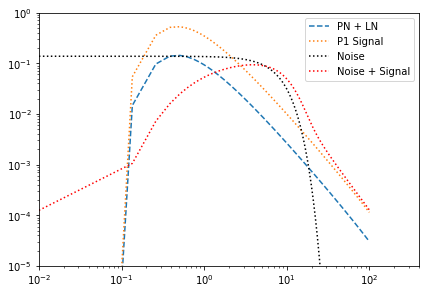

In [9]:
gs = gridspec.GridSpec(1, 1,left=0.1,bottom=0.1,right=0.98,top=0.98)
ax = plt.subplot(gs[0,0])


plt.plot(tary_meN, LIM_ary, label = 'PN + LN', linestyle = 'dashed')
plt.plot(tary_meN, P1_ary, label = 'P1 Signal', linestyle = 'dotted')

plt.plot(tary_meN, noise_ary, label = 'Noise', linestyle = 'dotted', color = 'black')

plt.plot(tary_meN, combined, label = 'Noise + Signal', linestyle = 'dotted', color = 'red')


plt.loglog()

ax.set_xlim(1e-2,4e2)
ax.set_ylim(1e-5,1)


plt.legend()